In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, model, interface, solvers, hf

In [2]:
U0 = 1
nk = 1001
filling = 2

hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
tb_model = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}


def model_U(U):
    int_model = {
        (0,): U * np.kron(np.eye(2), np.ones((2, 2))),
    }
    return model.Model(tb_model=tb_model, int_model=int_model)


model0 = model_U(U0)
model0.vectors = [*model0.int_model.keys()]
model0.random_guess(model0.vectors)
model0.kgrid_evaluation(nk=100)

In [3]:
hamiltonians_0 = utils.kgrid_hamiltonian(
    nk=nk, hk=utils.model2hk(tb_model=tb_model), dim=1
)


def groundstate(U):
    _model=model_U(U)
    tb_mf_k = interface.find_groundstate_ham(
        _model,
        filling=filling,
        nk=nk,
        solver=solvers.rspace_solver,
        cost_function=solvers.real_space_cost,
        return_kspace=True,
        optimizer_kwargs={},
    )
    vals, vecs = np.linalg.eigh(tb_mf_k)
    EF = utils.get_fermi_energy(vals, filling)
    densityMatrix = hf.density_matrix(vals, vecs, EF)

    return tb_mf_k, densityMatrix, _model.H_int

tb_mf0, densityMatrix0, H_int0 = groundstate(U0)
mf0 = tb_mf0 - hamiltonians_0


@np.vectorize
def mfRescaled(alpha, mf0=mf0, H_int0=H_int0):
    hamiltonian = hamiltonians_0 + mf0 * alpha
    vals, vecs = np.linalg.eigh(hamiltonian)
    EF = utils.get_fermi_energy(vals, filling)
    densityMatrix = hf.density_matrix(vals, vecs, EF)
    return hf.total_energy(
        hamiltonians_0 + np.sign(alpha) * mf0,
        densityMatrix,
    )

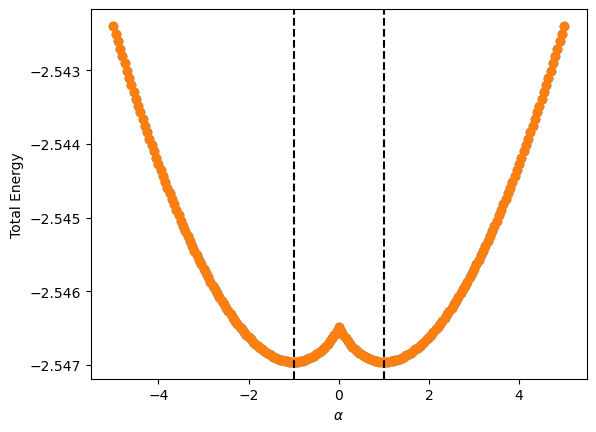

In [4]:
alphas = np.linspace(-5, 5, 201)
plt.plot(alphas, mfRescaled(alphas), 'o')
plt.plot(-alphas, mfRescaled(alphas), 'o')
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
plt.ylabel("Total Energy")
plt.xlabel(r"$\alpha$")
# plt.ylim(-4.6, -4.5)
plt.show()

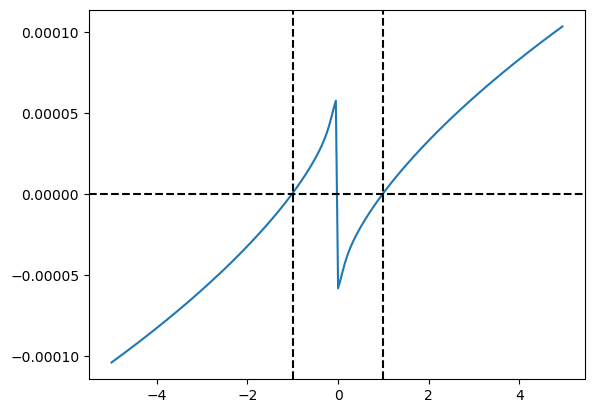

In [7]:
plt.plot(alphas[:-1], np.diff(mfRescaled(alphas)))
# plt.plot(-alphas[:-1], -np.diff(mfRescaled(alphas)))
plt.axhline(0, ls='--', c='k')
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
# plt.ylim(-4, -2)
plt.show()